In [1]:
from prophet import Prophet
import xgboost as xgb

import sys, os, yaml
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import yfinance as yf

/Users/truongnguyen/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
# Load inputs from inputs.yml
with open('inputs.yml', 'r') as file:
    inputs = yaml.safe_load(file)

# Access specific inputs
start_dt = inputs['params']['start_dt']
split_dt = inputs['params']['split_dt']

print(f"Start date: {start_dt}")
print(f"Split date: {split_dt}")

Start date: 2018-01-01
Split date: 2025-03-01


In [4]:
# Download SP500, NASDAQ, and VIX data
today_date = datetime.today().date()

sp500_data = yf.download('^GSPC',   start=start_dt, end=today_date.strftime('%Y-%m-%d'))
nasdaq_data = yf.download('^IXIC',  start=start_dt, end=today_date.strftime('%Y-%m-%d'))
vix_data = yf.download('^VIX',      start=start_dt, end=today_date.strftime('%Y-%m-%d'))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:

# Download TSLA stock price data
tsla_data = yf.download('TSLA', start=start_dt, end=today_date.strftime('%Y-%m-%d'))
tsla_data.columns = ['_'.join(col).strip() for col in tsla_data.columns.values]
tsla_data = tsla_data.reset_index()

display(tsla_data.head())
display(tsla_data.tail())

[*********************100%***********************]  1 of 1 completed


,Date,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA
0,2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000
1,2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500
2,2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500
3,2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000
4,2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000


,Date,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA
1834,2025-04-21,227.500000,232.210007,222.789993,230.259995,97768000
1835,2025-04-22,237.970001,242.789993,229.850006,230.960007,120858500
1836,2025-04-23,250.740005,259.450012,244.429993,254.860001,150381900
1837,2025-04-24,259.510010,259.540009,249.199997,250.500000,94464200
1838,2025-04-25,284.950012,286.850006,259.630005,261.690002,167560700


In [6]:
def preprocess_data(df_in, sticker='TSLA'):
    df = df_in.copy(deep=True)
    df['Date'] = pd.to_datetime(df['Date'])
    # column rename into Prophet format
    df.rename(columns={'Date': 'ds', 
                     f'Close_{sticker}': 'y',
                     f'High_{sticker}': 'high_value',
                     f'Low_{sticker}': 'low_value',
                     f'Open_{sticker}': 'open_value',
                     f'Volume_{sticker}': 'volume_value'}, inplace=True)
    
    # normalize volume values
    df['volume_value'] = df['volume_value'] / 1e6 # use millions for better readability
    exo_vars = ['high_value', 'low_value', 'open_value', 'volume_value']
    for col in exo_vars:
        df[col] = df[col].astype(float)
    
    return df, exo_vars

def clean_market_data(df_sp500_in, df_nasdaq_in, df_vix_in):
    df_sp500 = df_sp500_in.copy(deep=True)
    df_nasdaq = df_nasdaq_in.copy(deep=True)
    df_vix = df_vix_in.copy(deep=True)

    df_sp500.columns = ['_'.join(col).strip() for col in df_sp500.columns.values]
    df_nasdaq.columns = ['_'.join(col).strip() for col in df_nasdaq.columns.values]
    df_vix.columns = ['_'.join(col).strip() for col in df_vix.columns.values]

    # Convert index to datetime
    df_sp500.index = pd.to_datetime(df_sp500.index)
    df_nasdaq.index = pd.to_datetime(df_nasdaq.index)
    df_vix.index = pd.to_datetime(df_vix.index)

    # Resample to daily frequency and forward fill missing values
    df_sp500 = df_sp500.resample('D').ffill()
    df_nasdaq = df_nasdaq.resample('D').ffill()
    df_vix = df_vix.resample('D').ffill()

    # Reset index to have 'ds' column
    df_sp500.reset_index(inplace=True)
    df_nasdaq.reset_index(inplace=True)
    df_vix.reset_index(inplace=True)

    # Rename columns for consistency
    df_sp500.rename(columns={'Date': 'ds', 'Close_^GSPC': 'sp500_close', 'Volume_^GSPC': 'sp500_volume'}, inplace=True)
    df_nasdaq.rename(columns={'Date': 'ds', 'Close_^IXIC': 'nasdaq_close', 'Volume_^IXIC': 'nasdaq_volume'}, inplace=True)
    df_vix.rename(columns={'Date': 'ds', 'Close_^VIX': 'vix_close'}, inplace=True)

    df_market = df_sp500[['ds','sp500_close','sp500_volume']].merge(df_nasdaq[['ds','nasdaq_close','nasdaq_volume']], on='ds', how='left')
    df_market = df_market.merge(df_vix[['ds','vix_close']], on='ds', how='left')
    df_market['ds'] = pd.to_datetime(df_market['ds'])
    df_market = df_market.sort_values(by='ds').reset_index(drop=True)

    df_market['sp500_volume']  = df_market['sp500_volume'] / 1e6 # use millions for better readability
    df_market['nasdaq_volume'] = df_market['nasdaq_volume'] / 1e6 # use millions for better readability

    return df_market

def get_earnings_dates(sticker='TSLA'):
    # Select the stock
    ticker = yf.Ticker(sticker)  # Example: Apple
    # Get earnings dates
    earnings = ticker.get_earnings_dates(limit=40).reset_index()
    earnings = earnings.rename(columns={'Earnings Date': 'ds', 
                                        'EPS Estimate': 'eps_estimate', 
                                        'Reported EPS': 'reported_eps',
                                        'Surprise(%)': 'surprise_pct'})
    earnings['ds'] = earnings['ds'].dt.strftime('%Y-%m-%d')
    earnings['ds'] = pd.to_datetime(earnings['ds'])
    eps_vars = ['eps_estimate', 'reported_eps', 'surprise_pct']

    return earnings, eps_vars

def get_fred_inflation_data(exo_vars, start_date=start_dt):
    from fredapi import Fred
    # Your FRED API key here
    fred = Fred(api_key='e7bc3e975c7ef55f5e3bd20671a88973')
    # Pull U.S. CPI (Consumer Price Index for All Urban Consumers)
    cpi = fred.get_series('CPIAUCSL')
    df_cpi = pd.DataFrame(cpi).reset_index()
    df_cpi.columns = ['ds', 'cpi']
    df_cpi['ds'] = pd.to_datetime(df_cpi['ds'])
    df_cpi = df_cpi[df_cpi['ds'] >= start_date]  # Restrict to the same period as stock data
    exo_vars.append('cpi')

    # Ensure the data is sorted by date
    df_cpi = df_cpi.sort_values(by='ds')
    # Set the date column as the index
    df_cpi.set_index('ds', inplace=True)
    # Create a new date range with daily frequency
    daily_index = pd.date_range(start=df_cpi.index.min(), end=df_cpi.index.max(), freq='D')
    # Reindex the DataFrame to include the daily dates
    df_cpi_daily = df_cpi.reindex(daily_index)
    # Interpolate the missing values
    df_cpi_daily = df_cpi_daily.interpolate(method='linear')
    # Reset the index and rename the columns
    df_cpi_daily.reset_index(inplace=True)
    df_cpi_daily.rename(columns={'index': 'ds'}, inplace=True)
    return df_cpi_daily, exo_vars

def create_train_test_sets(df_in, split_date=split_dt, start_date=start_dt):
    df = df_in.copy(deep=True)
    # restrict start date for training set
    df = df[df['ds'] >= start_date]
    # drop weekends
    df['dayofweek'] = df['ds'].dt.dayofweek
    df = df[df['ds'].dt.dayofweek < 5]  # Keep only weekdays (Monday to Friday)
    train_df = df[df['ds'] < split_date]
    test_df = df[df['ds'] >= split_date]
    
    return df, train_df, test_df
    

In [7]:
def train_prophet_model(df_train, exo_vars):
    model = Prophet(
                changepoint_prior_scale=0.1,
                changepoint_range=0.7,
                n_changepoints=10,
                interval_width=0.7,
                yearly_seasonality=True,
                weekly_seasonality=True,
                seasonality_mode='multiplicative',
                daily_seasonality=False,
                seasonality_prior_scale=0.9,
            )
    model.add_seasonality(name='monthly', period=30, fourier_order=3, prior_scale=2.0)
    model.add_seasonality(name='quarterly', period=91, fourier_order=3, prior_scale=2.0)
    
    model.fit(df_train)
    
    return model

def create_residuals(df_train, forecast_prophet, exo_vars, eps_cols):
    df = df_train.copy(deep=True)
    df = df.merge(forecast_prophet[['ds', 'yhat']], on='ds', how='left')
    df['residuals'] = df['y'] - df['yhat']
    return df[['ds', 'y', 'yhat', 'residuals']+exo_vars+eps_cols]

def train_xgb_model(df_residuals, exo_vars, eps_cols):

    X = df_residuals[exo_vars+eps_cols]
    y = df_residuals['residuals']
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:absoluteerror',
        n_estimators=500,
        learning_rate=0.1,
        max_depth=5,
        reg_lambda=0.1,
        reg_alpha=0.1,
        gamma=0.1,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=420,
    )
    xgb_model.fit(X, y)
    return xgb_model

def make_prophet_forecast(df_in, prophet_model):
    df = df_in.copy(deep=True)
    # make forecast with prophet_model
    future = df[['ds']]
    forecast = prophet_model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def make_predictions(df_in, df_test, prophet_model, xgb_model, exo_vars, eps_cols, split_date=split_dt):
    df = df_in.copy(deep=True)
    # make forecast with prophet_model
    future = df_test[['ds']]    
    forecast = prophet_model.predict(future)
    forecast = forecast[forecast['ds'] >= split_date]
    # make residuals predictions with xgb_model
    X_test = df_test[df_test['ds'] >= split_date][exo_vars+eps_cols]
    forecast['residuals'] = xgb_model.predict(X_test)

    # combine predictions
    forecast['preds'] = forecast['yhat'] + forecast['residuals']
    return forecast

In [8]:
df, exo_vars = preprocess_data(tsla_data)
df_market = clean_market_data(sp500_data, nasdaq_data, vix_data)
df = df.merge(df_market, on='ds', how='left')

df_earnings, eps_cols = get_earnings_dates(sticker='TSLA')
df = df.merge(df_earnings, on='ds', how='left')

df_cpi, exo_vars = get_fred_inflation_data(exo_vars, start_date=start_dt)
df = df.merge(df_cpi, on='ds', how='left')

df_market_cols = df_market.columns.tolist()
df_market_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_market_cols)

print("using exogeneous features:", exo_vars)

df, df_train, df_test = create_train_test_sets(df, split_date=split_dt, start_date=start_dt)

using exogeneous features: ['high_value', 'low_value', 'open_value', 'volume_value', 'cpi', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close']


In [9]:
df_test.head()

,ds,y,high_value,low_value,open_value,volume_value,sp500_close,sp500_volume,nasdaq_close,nasdaq_volume,vix_close,eps_estimate,reported_eps,surprise_pct,cpi,dayofweek
1800,2025-03-03,284.649994,303.940002,277.299988,300.339996,115.5514,5849.720215,5613.85,18350.189453,8170.14,22.780001,NaN,NaN,NaN,NaN,0
1801,2025-03-04,272.040009,284.350006,261.839996,270.929993,126.7066,5778.149902,6138.11,18285.160156,8469.18,23.510000,NaN,NaN,NaN,NaN,1
1802,2025-03-05,279.100006,279.549988,267.709991,272.920013,94.0429,5842.629883,5285.97,18552.730469,7048.43,21.930000,NaN,NaN,NaN,NaN,2
1803,2025-03-06,263.450012,272.649994,260.019989,272.059998,98.4516,5738.520020,5165.08,18069.259766,7686.20,24.870001,NaN,NaN,NaN,NaN,3
1804,2025-03-07,262.670013,266.250000,250.729996,259.320007,102.3696,5770.200195,5705.14,18196.220703,8135.42,23.370001,NaN,NaN,NaN,NaN,4


In [10]:
prophet_model = train_prophet_model(df_train, exo_vars)
forecast = make_prophet_forecast(df, prophet_model)
df_residuals = create_residuals(df_train, forecast, exo_vars, eps_cols)

xgb_model = train_xgb_model(df_residuals, exo_vars, eps_cols)
df_results = make_predictions(df_residuals, df_test, prophet_model, xgb_model, exo_vars, eps_cols, split_date=split_dt)

21:57:55 - cmdstanpy - INFO - Chain [1] start processing
21:57:56 - cmdstanpy - INFO - Chain [1] done processing


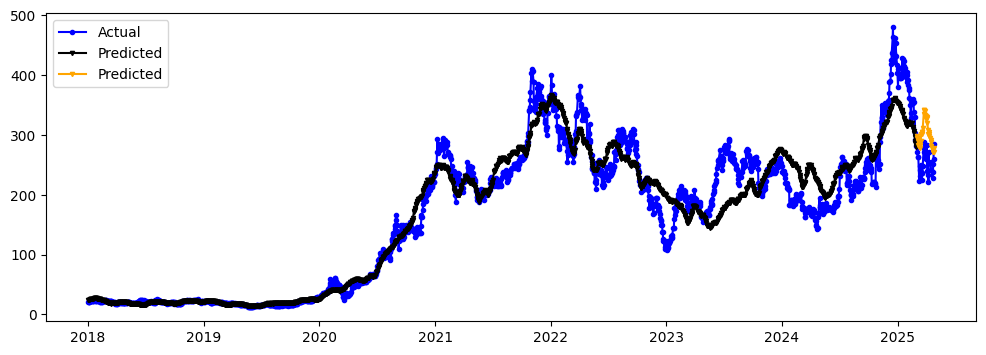

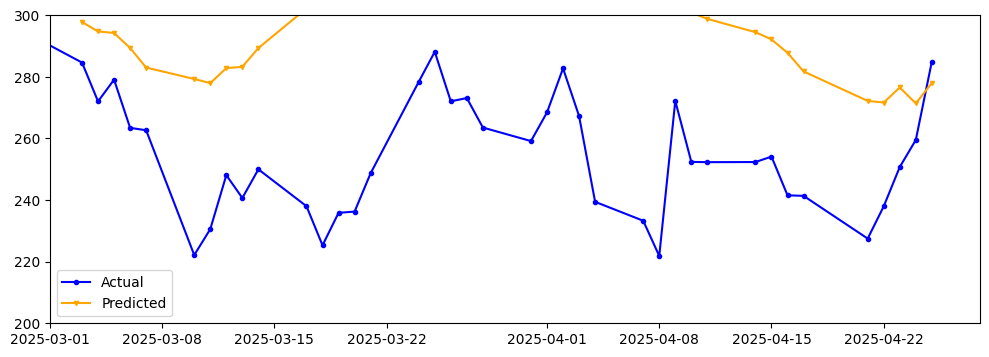

In [11]:
df1 = forecast[forecast['ds'] < '2025-03-01'].copy(deep=True)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],           df['y'],              label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df1['ds'],          df1['yhat'],             label='Predicted', color='black',   marker='v', markersize=3)
plt.plot(df_results['ds'],   df_results['preds'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],           df['y'],              label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df_results['ds'],   df_results['preds'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.xlim(pd.to_datetime(split_dt), pd.to_datetime(today_date))
plt.legend()
plt.ylim(200, 300)
plt.show()

In [12]:
# Now assume we do not have the actual values for the test set
# We need to predict values of exogenous variables for the test set
def predict_future_exo_vars(df_train, df_test, exo_vars):
    df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
    df_exo_vars_forecast = df[['ds']].copy(deep=True)
    print(exo_vars)
    # making raw forecasts for exogenous variables
    for var in exo_vars:
        print(var)
        # if var == 'cpi':
        #     # do simple forecast for cpi
        #     # Fill missing CPI values using linear interpolation
        #     df_train_var[var] = df_train[var].interpolate(method='linear')
        #     df = df_train_var[['ds', var]].copy(deep=True)

        #     # Extend the forecast for CPI into the future
        #     future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), end='2025-04-30', freq='D')
        #     future_cpi = pd.DataFrame({'ds': future_dates})

        #     # Assume a simple trend for CPI (e.g., using the last known rate of change)
        #     last_known_cpi = df['cpi'].iloc[-1]
        #     cpi_rate_of_change = df['cpi'].pct_change().mean()  # Average percentage change
        #     future_cpi['cpi'] = last_known_cpi * (1 + cpi_rate_of_change) ** (future_cpi.index + 1)

        #     # Combine with the original dataset
        #     df_exo_vars_forecast = df_exo_vars_forecast.merge(future_cpi[['ds', 'cpi']], on='ds', how='left')
        # else:
        m = Prophet(
                changepoint_prior_scale=0.5,
                changepoint_range=0.8,
                n_changepoints=10,
                interval_width=0.5,
                yearly_seasonality=True,
                weekly_seasonality=True,
                seasonality_mode='multiplicative',
                daily_seasonality=False,
                seasonality_prior_scale=0.5,
            )
        m.add_seasonality(name='monthly', period=30, fourier_order=3, prior_scale=2.0)
        m.add_seasonality(name='quarterly', period=91, fourier_order=3, prior_scale=2.0)
        df_train_var = df_train[['ds', var]].rename(columns={var: 'y'})
        m.fit(df_train_var)
        future = df[['ds']].copy(deep=True)
        forecast = m.predict(future)
        df_exo_vars_forecast = df_exo_vars_forecast.merge(forecast[['ds', 'yhat']], on='ds', how='left')
        df_exo_vars_forecast.rename(columns={'yhat': var}, inplace=True)
    # for eps variables we use the earnings dates
    earnings, _ = get_earnings_dates(sticker='TSLA')
    df_exo_vars_forecast = df_exo_vars_forecast.merge(earnings[['ds', 'eps_estimate', 'reported_eps', 'surprise_pct']], on='ds', how='left')
    return df_exo_vars_forecast

In [13]:
df_exo_vars_forecast = predict_future_exo_vars(df_train, df_test, exo_vars)
df_exo_vars_forecast.head()

21:57:57 - cmdstanpy - INFO - Chain [1] start processing


['high_value', 'low_value', 'open_value', 'volume_value', 'cpi', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close']
high_value


21:57:57 - cmdstanpy - INFO - Chain [1] done processing
21:57:57 - cmdstanpy - INFO - Chain [1] start processing


low_value


21:57:57 - cmdstanpy - INFO - Chain [1] done processing
21:57:57 - cmdstanpy - INFO - Chain [1] start processing
21:57:58 - cmdstanpy - INFO - Chain [1] done processing


open_value


21:57:58 - cmdstanpy - INFO - Chain [1] start processing


volume_value


21:57:58 - cmdstanpy - INFO - Chain [1] done processing
21:57:58 - cmdstanpy - INFO - Chain [1] start processing


cpi


21:57:58 - cmdstanpy - INFO - Chain [1] done processing
21:57:59 - cmdstanpy - INFO - Chain [1] start processing


sp500_close


21:57:59 - cmdstanpy - INFO - Chain [1] done processing
21:57:59 - cmdstanpy - INFO - Chain [1] start processing


sp500_volume


21:57:59 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_close


21:58:00 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_volume


21:58:00 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing


vix_close


21:58:01 - cmdstanpy - INFO - Chain [1] done processing


,ds,high_value,low_value,open_value,volume_value,cpi,sp500_close,sp500_volume,nasdaq_close,nasdaq_volume,vix_close,eps_estimate,reported_eps,surprise_pct
0,2018-01-02,22.365791,22.198782,22.634656,77.765862,248.666422,2629.683659,2862.817893,6892.430050,1950.534128,15.558284,NaN,NaN,NaN
1,2018-01-03,22.443340,22.300233,22.675731,77.564848,248.683715,2629.972358,2924.902685,6884.444239,1963.526204,15.211453,NaN,NaN,NaN
2,2018-01-04,22.545983,22.357065,22.803052,81.673792,248.718211,2632.321360,2977.164460,6883.488811,1977.702146,15.088172,NaN,NaN,NaN
3,2018-01-05,22.628107,22.504962,22.866633,80.340259,248.749401,2636.547502,3131.021450,6889.147261,2000.984047,14.589089,NaN,NaN,NaN
4,2018-01-08,23.589637,23.332372,23.693721,80.893652,248.822877,2657.286490,3046.720981,6951.015608,1946.785051,14.226328,NaN,NaN,NaN


In [ ]:
def predict_with_unk_future_exo_vars(df_in, df_train, df_test, prophet_model, xgb_model, exo_vars, eps_cols, split_date='2025-03-01'):
    df = df_in.copy(deep=True)
    df_test.reset_index(drop=True, inplace=True)
    # future = model.make_future_dataframe(periods=len(df_test), freq='D')
    future = df[['ds']]
    forecast = prophet_model.predict(future)
    forecast = forecast[forecast['ds'] >= split_date]
    # making predictions with xgb_model for residuals
    X_test = df[df['ds'] >= split_date][exo_vars+eps_cols]

    print(exo_vars)

    forecast['residuals'] = xgb_model.predict(X_test)
    # combine predictions
    forecast['preds'] = forecast['yhat'] + forecast['residuals']
    forecast = forecast[['ds', 'yhat', 'residuals', 'preds']].copy(deep=True)
    
    return forecast

forecast = predict_with_unk_future_exo_vars(df_exo_vars_forecast, df_train, df_test, prophet_model, xgb_model, exo_vars, eps_cols, split_date=split_dt)

['high_value', 'low_value', 'open_value', 'volume_value', 'cpi', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close']


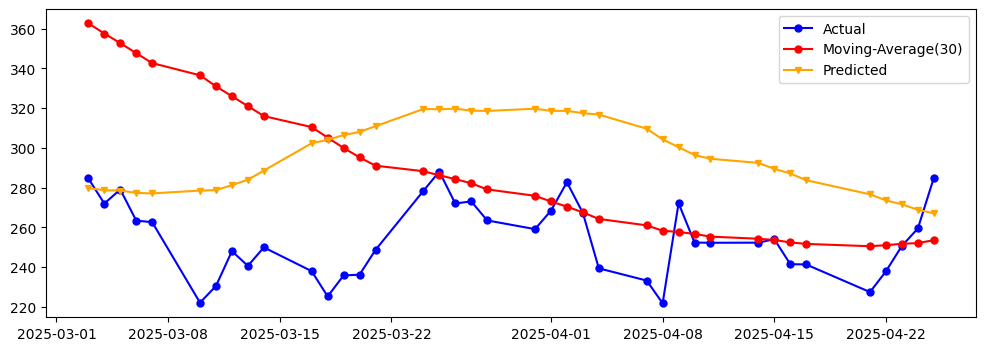

In [16]:
split_date = split_dt
df1 = forecast[forecast['ds'] >= split_date].copy(deep=True)

df['y_moving_avg'] = df['y'].rolling(window=30).mean()
df2 = df[df['ds'] >= split_date].copy(deep=True)



fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df2['ds'], df2['y'],     label='Actual',    color='blue',   marker='o', markersize=5)
plt.plot(df2['ds'], df2['y_moving_avg'], label='Moving-Average(30)',    color='red',   marker='o', markersize=5)
plt.plot(df1['ds'], df1['yhat'],  label='Predicted', color='orange', marker='v', markersize=5)
plt.legend()

high_value


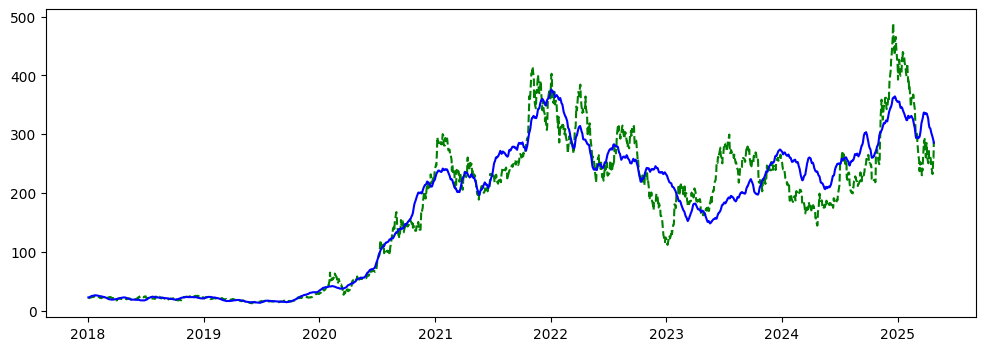

low_value


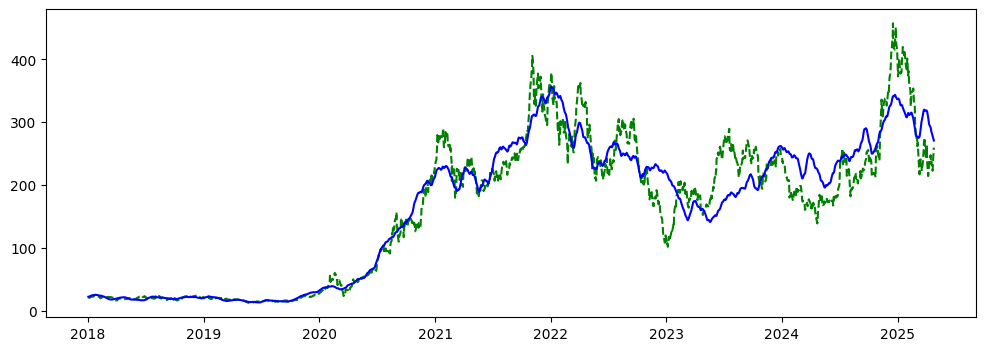

open_value


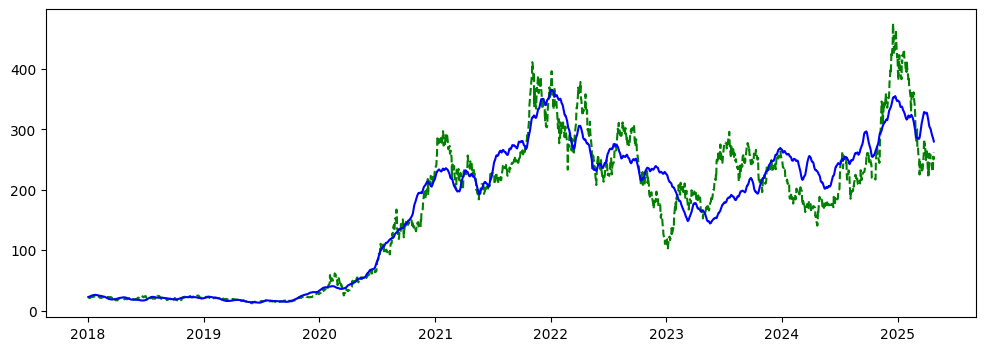

volume_value


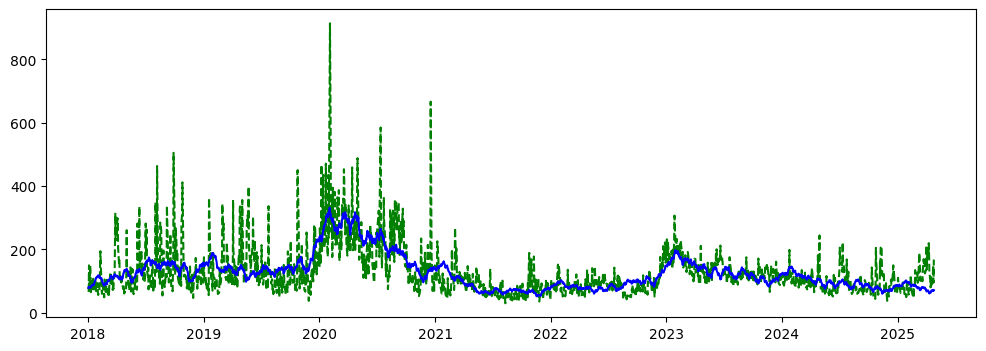

cpi


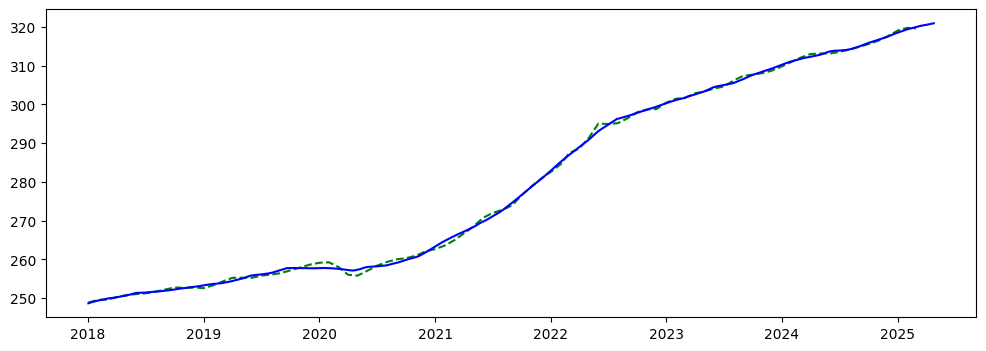

sp500_close


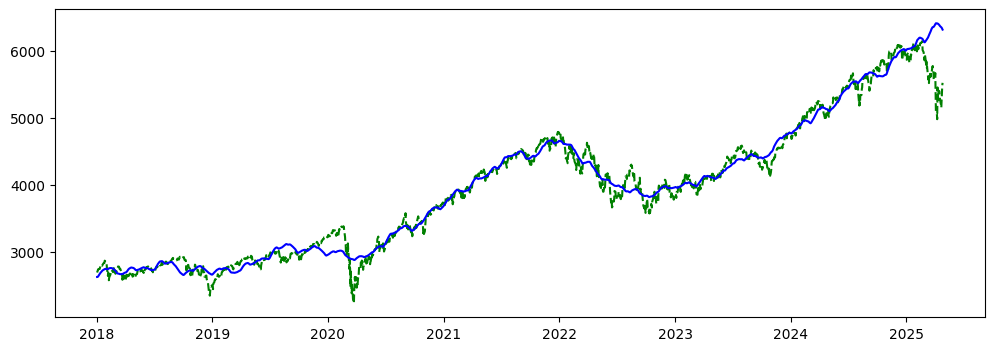

sp500_volume


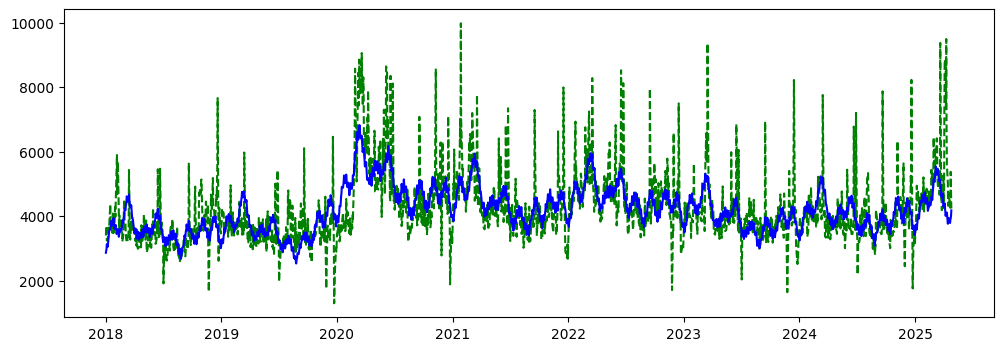

nasdaq_close


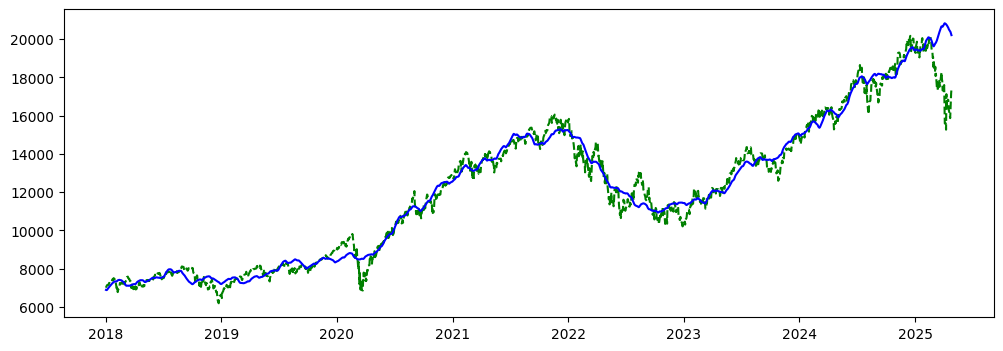

nasdaq_volume


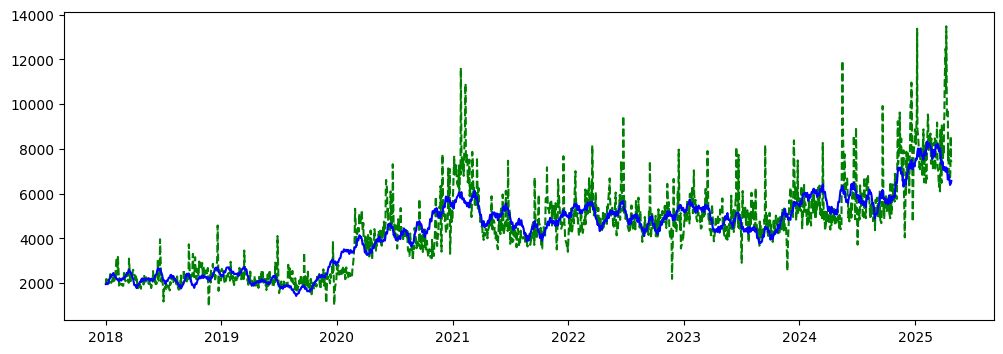

vix_close


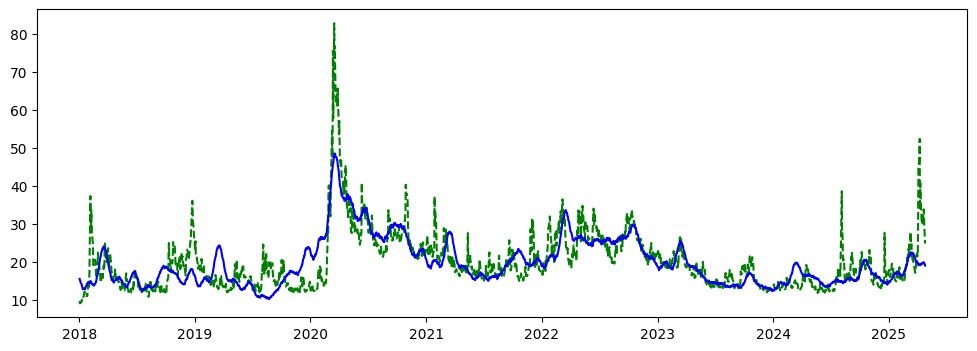

In [18]:
for exo_var_ in exo_vars:
    print(exo_var_)
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.plot(df['ds'], df[exo_var_], label='CPI', color='green', linestyle='--')
    plt.plot(df_exo_vars_forecast['ds'], df_exo_vars_forecast[exo_var_], label='CPI', color='blue', linestyle='-')
    plt.show()

In [22]:
# Now we gonna make real predictions for future unknown dates
df, exo_vars = preprocess_data(tsla_data)
df_market = clean_market_data(sp500_data, nasdaq_data, vix_data)
df = df.merge(df_market, on='ds', how='left')

df_earnings, eps_cols = get_earnings_dates(sticker='TSLA')
df = df.merge(df_earnings, on='ds', how='left')

df_cpi, exo_vars = get_fred_inflation_data(exo_vars, start_date=start_dt)
# need to check if cpi data is up to date, If not we need to update it using simple linear interpolation
# Fill missing CPI values using linear interpolation
df_cpi['cpi'] = df_cpi['cpi'].interpolate(method='linear')

# Extend the forecast for CPI into the future
future_dates = pd.date_range(start=df_cpi['ds'].max() + pd.Timedelta(days=1), end=today_date, freq='D')
future_cpi = pd.DataFrame({'ds': future_dates})

# Assume a simple trend for CPI (e.g., using the last known rate of change)
last_known_cpi = df_cpi['cpi'].iloc[-1]
cpi_rate_of_change = df_cpi['cpi'].pct_change().mean()  # Average percentage change
future_cpi['cpi'] = last_known_cpi * (1 + cpi_rate_of_change) ** (future_cpi.index + 1)
df_cpi = pd.concat([df_cpi, future_cpi], axis=0, ignore_index=True)
df = df.merge(df_cpi, on='ds', how='left')

df_market_cols = df_market.columns.tolist()
df_market_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_market_cols)

print("using exogeneous features:", exo_vars)

df_train = df.copy(deep=True)

# train prophet and xgb models
eps_cols = []
prophet_model = train_prophet_model(df_train, exo_vars)
forecast = make_prophet_forecast(df, prophet_model)
df_residuals = create_residuals(df_train, forecast, exo_vars, eps_cols)
xgb_model = train_xgb_model(df_residuals, exo_vars, eps_cols)

22:00:59 - cmdstanpy - INFO - Chain [1] start processing


using exogeneous features: ['high_value', 'low_value', 'open_value', 'volume_value', 'cpi', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close']


22:00:59 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
def generate_forecasts_for_future_dates(df_in, exo_vars, start_fc_date=None, end_fc_date=None):
    df = df_in.copy(deep=True)

    start_fc_date = pd.to_datetime(start_fc_date)
    end_fc_date   = pd.to_datetime(end_fc_date)
    num_days = (end_fc_date - start_fc_date).days
    df_exo_vars_forecast = pd.DataFrame({'ds': pd.date_range(start=start_fc_date, end=end_fc_date, freq='D')})
    df_exo_vars_forecast = df_exo_vars_forecast[df_exo_vars_forecast['ds'].dt.dayofweek < 5]  # Keep only weekdays (Monday to Friday)

    for var in exo_vars:
        print(var)
        m = Prophet(
                changepoint_prior_scale=0.5,
                changepoint_range=0.8,
                n_changepoints=10,
                interval_width=0.5,
                yearly_seasonality=True,
                weekly_seasonality=True,
                seasonality_mode='multiplicative',
                daily_seasonality=False,
                seasonality_prior_scale=0.5,
            )
        m.add_seasonality(name='monthly', period=30, fourier_order=3, prior_scale=2.0)
        m.add_seasonality(name='quarterly', period=91, fourier_order=3, prior_scale=2.0)
        df_train_var = df[['ds', var]].rename(columns={var: 'y'})
        m.fit(df_train_var)

        future = m.make_future_dataframe(periods=num_days, freq='D')
        future = future[future['ds'].dt.dayofweek < 5]  # Keep only weekdays (Monday to Friday)
        forecast = m.predict(future)
        df_exo_vars_forecast = df_exo_vars_forecast.merge(forecast[['ds', 'yhat']], on='ds', how='left')
        df_exo_vars_forecast.rename(columns={'yhat': var}, inplace=True)

    return df_exo_vars_forecast

df_exo_vars_forecast = generate_forecasts_for_future_dates(df_residuals, exo_vars, start_fc_date='2025-04-26', end_fc_date='2025-06-30')

22:11:58 - cmdstanpy - INFO - Chain [1] start processing


high_value


22:11:58 - cmdstanpy - INFO - Chain [1] done processing
22:11:59 - cmdstanpy - INFO - Chain [1] start processing


low_value


22:11:59 - cmdstanpy - INFO - Chain [1] done processing
22:11:59 - cmdstanpy - INFO - Chain [1] start processing


open_value


22:11:59 - cmdstanpy - INFO - Chain [1] done processing
22:11:59 - cmdstanpy - INFO - Chain [1] start processing


volume_value


22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:00 - cmdstanpy - INFO - Chain [1] start processing


cpi


22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:00 - cmdstanpy - INFO - Chain [1] start processing


sp500_close


22:12:01 - cmdstanpy - INFO - Chain [1] done processing
22:12:01 - cmdstanpy - INFO - Chain [1] start processing


sp500_volume


22:12:01 - cmdstanpy - INFO - Chain [1] done processing
22:12:01 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_close


22:12:02 - cmdstanpy - INFO - Chain [1] done processing
22:12:02 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_volume


22:12:02 - cmdstanpy - INFO - Chain [1] done processing
22:12:02 - cmdstanpy - INFO - Chain [1] start processing


vix_close


22:12:02 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
df_exo_vars_forecast

,ds,high_value,low_value,open_value,volume_value,cpi,sp500_close,sp500_volume,nasdaq_close,nasdaq_volume,vix_close
0,2025-04-28,282.491047,266.196725,274.877408,92.376569,321.149428,6017.001708,4320.218976,19007.994115,6772.229081,22.241838
1,2025-04-29,281.851110,266.217281,275.595573,87.884864,321.183537,6036.433205,4452.659998,19078.371407,6954.681994,21.964693
2,2025-04-30,282.854303,267.346161,275.967465,83.200963,321.192742,6057.473954,4541.189277,19158.474447,7129.761548,21.644040
3,2025-05-01,284.380820,268.521237,278.320566,84.254645,321.221013,6074.722896,4592.908597,19225.202612,7206.386203,21.592723
4,2025-05-02,285.716215,270.318671,279.295515,80.525012,321.241307,6096.399566,4788.910207,19313.356478,7374.389083,21.010969
5,2025-05-05,290.593892,271.373643,281.810997,81.896649,321.298319,6144.239187,4595.618597,19515.727597,7552.600572,20.823031
6,2025-05-06,288.325363,269.067797,280.704392,79.553605,321.337527,6154.869947,4719.949178,19557.632564,7887.357970,20.620532
7,2025-05-07,286.103312,266.518763,277.771508,76.611037,321.356517,6165.332986,4795.642545,19596.549809,8214.505198,20.465962
8,2025-05-08,283.477246,263.530295,276.095581,78.125564,321.398125,6171.399633,4822.478831,19616.214755,8409.210138,20.648992
9,2025-05-09,280.697346,261.756316,273.298218,73.239757,321.432900,6182.431902,4975.589464,19658.822488,8626.608334,20.314739


In [67]:
def predict_with_unk_future_exo_vars(df_exo_vars_forecast_in, 
                                     prophet_model, xgb_model, exo_vars, eps_cols,
                                     start_fc_dt=None,
                                     end_fc_dt=None,
                                     ):
    df = df_exo_vars_forecast_in.copy(deep=True)

    
    start_fc_dt = pd.to_datetime(start_fc_dt)
    end_fc_dt   = pd.to_datetime(end_fc_dt)
    num_days = (end_fc_dt - start_fc_dt).days + 1
    # future = model.make_future_dataframe(periods=len(df_test), freq='D')
    future = prophet_model.make_future_dataframe(periods=num_days, freq='D')
    future = future[future['ds'].dt.dayofweek < 5]  # Keep only weekdays (Monday to Friday)
    forecast = prophet_model.predict(future)
    forecast_historical = forecast[forecast['ds'] < start_fc_dt]
    forecast = forecast[forecast['ds'] >= start_fc_dt]
    # making predictions with xgb_model for residuals
    X_test = df[df['ds'] >= start_fc_dt][exo_vars+eps_cols]

    print(exo_vars)

    forecast['residuals'] = xgb_model.predict(X_test)
    # combine predictions
    forecast['preds'] = forecast['yhat'] + forecast['residuals']
    forecast = forecast[['ds', 'yhat', 'residuals', 'preds']].copy(deep=True)
    
    return forecast, forecast_historical[['ds', 'yhat']]

df_results, forecast_historical = predict_with_unk_future_exo_vars(
                                        df_exo_vars_forecast,
                                        prophet_model, xgb_model, exo_vars, eps_cols,
                                        start_fc_dt='2025-04-26',
                                        end_fc_dt='2025-06-30',
                                    )

['high_value', 'low_value', 'open_value', 'volume_value', 'cpi', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close']


(150.0, 450.0)

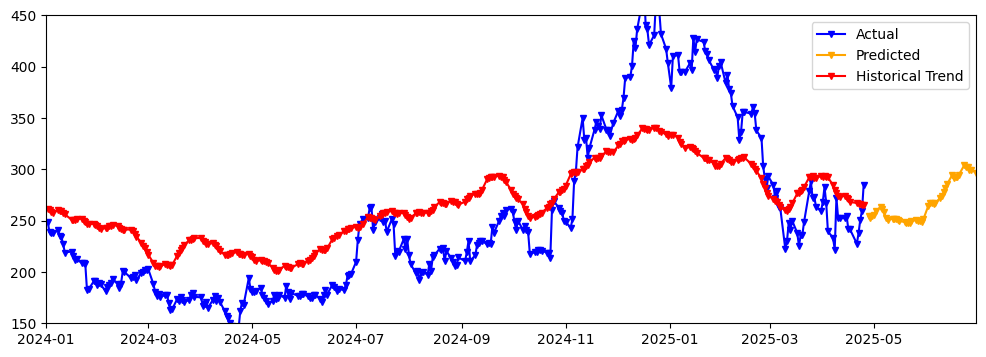

In [80]:
df1 = forecast_historical.copy(deep=True)
df1.rename(columns={'yhat': 'preds'}, inplace=True)
df1 = pd.concat([df1, df_results], axis=0, ignore_index=True)
df1   = df1[df1['ds'] < '2025-04-26'].copy(deep=True)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],         df['y'],             label='Actual', color='blue', marker='v', markersize=5)
plt.plot(df_results['ds'], df_results['preds'], label='Predicted',  color='orange', marker='v', markersize=5)
plt.plot(df1['ds'], df1['preds'], label='Historical Trend',  color='red', marker='v', markersize=5)
plt.legend()
plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2025-06-30'))
plt.ylim([150, 450])